
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1000
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:      204
                     variables with only lower bounds:      201
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality co

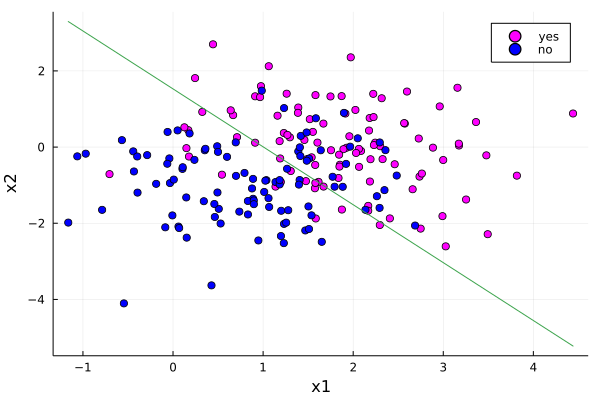

In [1]:
using DataFrames, CSV, LinearAlgebra
using Plots, StatsModels, StatsBase
using JuMP, Ipopt

function svm2(A, y; C=100)  # separable data, but nonlinear constraint
    (m,n) = size(A)
    model = Model(Ipopt.Optimizer)
    @variable(model, M >= 0)       # the margin
    @variable(model, β[1:n])       # model parameters
    @variable(model, s[1:m] >= 0); # slack variables
    
    for i in 1:m
        @constraint(model, y[i]*(β'*A[i,:]) >= 1-s[i])
    end
    @constraint(model, sum(s[i] for i in 1:m) <= C)
    @NLobjective(model, Min, M^-2)

    optimize!(model)
    println("objective value = ", objective_value(model))
    println("solution = ", value.(β))
    return value.(β)
end

# two-class data
df = CSV.read("two-class-data.csv", DataFrame)

fo = @formula(y ~ 1 + x1 + x2)
A = modelmatrix(fo.rhs, df)
y = vec(modelmatrix(fo.lhs, df))

β = svm2(A, y; C=98)         # obtain the model parameters

f(x) = (-β[1] - β[2]*x)/β[3] # decision boundary helper function

yes = findall(x->x==1, y)    # indices for the +1 class
no  = findall(x->x==-1, y)   # indices for the -1 class

# plot the data and the decision boundary
scatter(df.x1[yes], df.x2[yes], color=:magenta, label="yes")
scatter!(df.x1[no], df.x2[no], color=:blue, label="no")
plot!(df.x1, f.(df.x1), label="", xlabel="x1", ylabel="x2")

c.
The trade-off with a large C is that our tolerance for violations increases therefore making our margin larger, however, with a larger margin and a larger C would mean that there will be a larger amount of error in our misclassified terms. So the trade-off is between a larger margin with a larger amount of misclassification error or a smaller margin with less misclassification errors.